In [56]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sys 
sys.path.append("/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping")
from utils import plot_phasemap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

from apdist.distances import AmplitudePhaseDistance as dist
from activephasemap.simulators import UVVisExperiment

#### Plotting utils

In [44]:
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

def prettify_axis(ax):
    ax.set_xlabel(r"Silver Nitrate ($10^{-4}$ M)")
    ax.set_ylabel(r"Ascorbic Acid ($10^{-3}$ M)")
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

    SN_labels = [item.get_text() for item in ax.get_xticklabels()]
    SN_vol_to_conc = lambda v : (6.4*v)/(300)
    SN_conc_labels = []
    for l in SN_labels:
        SN_conc_labels.append("%.2f"%SN_vol_to_conc(float(l)))
    ax.set_xticklabels(SN_conc_labels)

    AA_labels = [item.get_text() for item in ax.get_yticklabels()]
    AA_vol_to_conc = lambda v : (6.3*v)/(300)
    AA_conc_labels = []
    for l in AA_labels:
        AA_conc_labels.append("%.2f"%AA_vol_to_conc(float(l)))
    ax.set_yticklabels(AA_conc_labels)

    return ax

### Load iters data

In [45]:
bounds = np.asarray(design_space_bounds).T 
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(14)
expt.generate(use_spline=True)

Loading data from iteration 0 with shapes: (12, 2) (12, 101)
Loading data from iteration 1 with shapes: (6, 2) (6, 101)
Loading data from iteration 2 with shapes: (6, 2) (6, 101)
Loading data from iteration 3 with shapes: (6, 2) (6, 101)
Loading data from iteration 4 with shapes: (6, 2) (6, 101)
Loading data from iteration 5 with shapes: (6, 2) (6, 101)
Loading data from iteration 6 with shapes: (6, 2) (6, 101)
Loading data from iteration 7 with shapes: (6, 2) (6, 101)
Loading data from iteration 8 with shapes: (6, 2) (6, 101)
Loading data from iteration 9 with shapes: (6, 2) (6, 101)
Loading data from iteration 10 with shapes: (6, 2) (6, 101)
Loading data from iteration 11 with shapes: (6, 2) (6, 101)
Loading data from iteration 12 with shapes: (6, 2) (6, 101)
Loading data from iteration 13 with shapes: (6, 2) (6, 101)


In [46]:
water_uvvis = pd.read_excel("../uvvis/water.xlsx", engine='openpyxl')
water = water_uvvis.iloc[:,-1].to_numpy()
wavelength = water_uvvis["Wavelength"].to_numpy()

### Read repeat data from 01/31/2025

In [47]:
volumes_all_iters = pd.read_csv("../opentrons/volumes_all_iters.csv")
uvvis_0131 = pd.read_excel("./uvvis_all_iters_0131.xlsx", engine='openpyxl')
well_names = uvvis_0131.columns[1:].to_numpy()
spectra = []
for well_name in well_names:
    y = uvvis_0131[well_name].values-water
    spectra.append(y)

spectra_all_0131 = np.asarray(spectra)
all_comps = volumes_all_iters[["SN", "AA"]].to_numpy()

## Read repeat data from 02/12/2025

In [48]:
uvvis_0212 = pd.read_excel("./uvvis_all_iters_0212.xlsx", engine='openpyxl')
well_names = uvvis_0212.columns[1:].to_numpy()
spectra = []
for well_name in well_names:
    y = uvvis_0212[well_name].values-water
    spectra.append(y)

spectra_all_0212 = np.asarray(spectra)

## Visualize changes between different batches

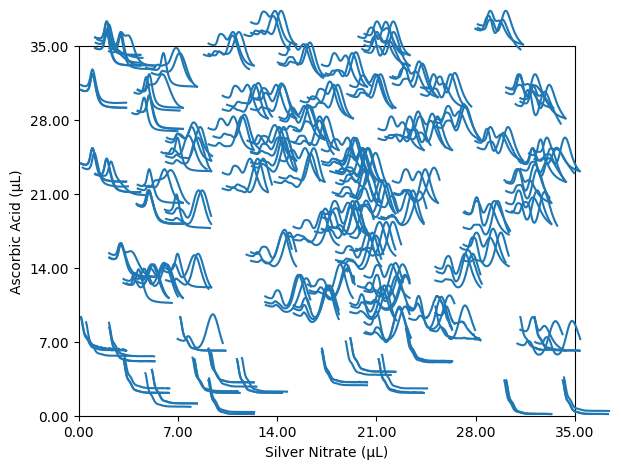

In [49]:

fig, ax = plt.subplots()
plot_phasemap(bounds, ax, expt.comps, expt.spectra, color="tab:blue")
plot_phasemap(bounds, ax, all_comps, spectra_all_0131, color="tab:blue")
plot_phasemap(bounds, ax, all_comps, spectra_all_0212, color="tab:blue")
ax.set_xlabel("Silver Nitrate (µL)")
ax.set_ylabel("Ascorbic Acid (µL)")
plt.show()


## Visualize shape change over composition

In [50]:
all_dists = []
optim_kwargs = {"optim":"DP", "grid_dim":10}

for i in range(expt.comps.shape[0]):
    f_ref = expt.spectra[i,:]
    f_query_0131 = spectra_all_0131[i,:]
    f_query_0212 = spectra_all_0212[i,:]
    t = (expt.wav - min(expt.wav))/(max(expt.wav) - min(expt.wav))
    _, phase_0131 = dist(t, f_ref, f_query_0131, **optim_kwargs)
    _, phase_0212 = dist(t, f_ref, f_query_0212, **optim_kwargs)
    all_dists.append([phase_0131, phase_0212])
all_dists = np.asarray(all_dists)

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3737/807014969.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3737/807014969.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3737/807014969.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3737/807014969.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


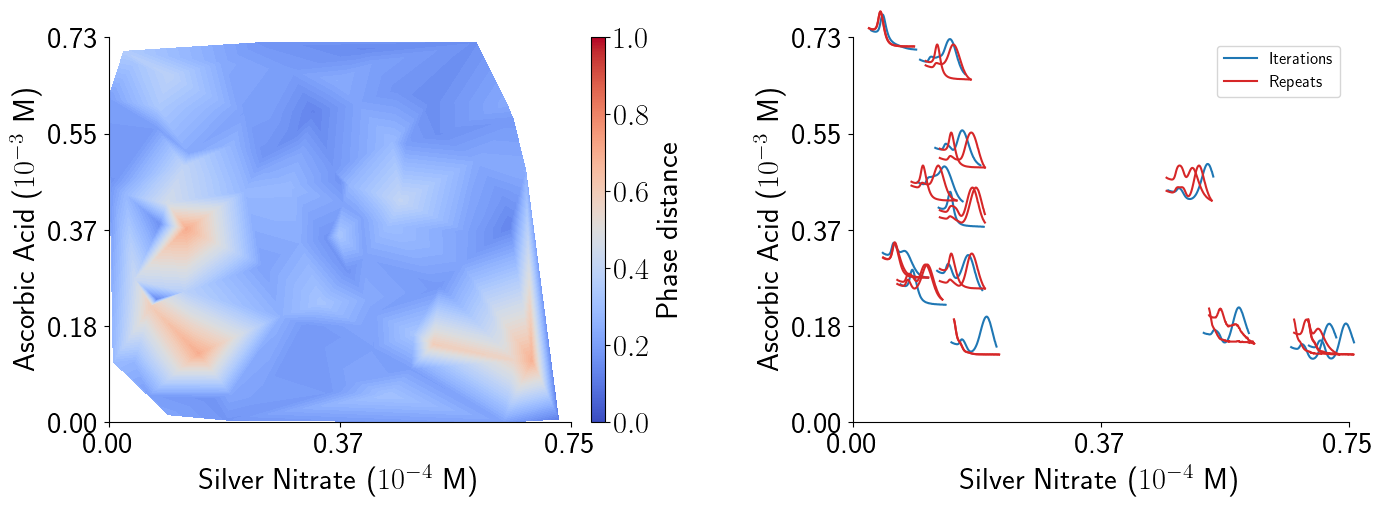

In [60]:
with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(1,2, figsize=(5*2*1.6, 5))
    fig.subplots_adjust(wspace=0.5)
    ax = axs[0]
    norm = Normalize(vmin=0, vmax=1.0)
    cmap = "coolwarm"
    z = all_dists.mean(axis=1)
    ax.tricontourf(expt.comps[:,0], 
                expt.comps[:,1], 
                z, 
                cmap=cmap, 
                norm=norm,
                levels = 50
                )
#     ax.scatter(expt.comps[:,0],
#             expt.comps[:,1], 
#             s=z*100, 
#             color="k"
#             )

    mappable = ScalarMappable(norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.2)
    cbar = fig.colorbar(mappable,shrink=0.5, aspect=5,cax=cax)
    cbar.ax.set_ylabel('Phase distance', rotation=90)
    prettify_axis(ax)

    flags = z>0.35
    ax = axs[1]
    plot_phasemap(bounds, ax, expt.comps[flags,:], expt.spectra[flags,:], color="tab:blue")
    plot_phasemap(bounds, ax, all_comps[flags,:], spectra_all_0131[flags,:], color="tab:red")
    plot_phasemap(bounds, ax, all_comps[flags,:], spectra_all_0212[flags,:], color="tab:red")

    blue_line = mlines.Line2D([], [], color='tab:blue', label='Iterations')
    red_line = mlines.Line2D([], [], color='tab:red', label='Repeats')
    ax.legend(handles = [blue_line, red_line], 
               ncol=1, 
               loc='best', 
               prop={'size': 12}
               )
    prettify_axis(ax)

    plt.savefig("../paper/figures/batch_effects_noise.png")
    plt.show()